# Topic Modeling with LDA
This notebook walks through the complete process of topic modeling using Latent Dirichlet Allocation (LDA) on research paper abstracts.

In [5]:
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Configuration
DATA_PATH = "../data/simulated_research_papers.csv"
MODEL_DIR = "model"
MODEL_PATH = os.path.join(MODEL_DIR, "lda_model.pkl")
VECTORIZER_PATH = os.path.join(MODEL_DIR, "vectorizer.pkl")
TOPIC_KEYWORDS_PATH = os.path.join(MODEL_DIR, "topic_keywords.pkl")

## Load and Explore Dataset

In [6]:
df = pd.read_csv(DATA_PATH)
df.shape, df.columns.tolist()

((2000, 2), ['Title', 'Abstract'])

In [9]:
df.head()

,Title,Abstract
0,Trouble happen return front would.,AI methods are used to predict climate pattern...
1,Face somebody certain music suffer radio recent.,This paper explores the use of big data techno...
2,Water food last real six pattern.,AI methods are used to predict climate pattern...
3,Activity person economic world south.,Graph neural networks have revolutionized the ...
4,Defense much religious happen seem.,Graph neural networks have revolutionized the ...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     2000 non-null   object
 1   Abstract  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [8]:
df.describe()

,Title,Abstract
count,2000,2000
unique,2000,10
top,Trouble happen return front would.,AI methods are used to predict climate pattern...
freq,1,216


## Text Preprocessing and Vectorization

In [10]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_counts = vectorizer.fit_transform(df['Abstract'])
X_counts.shape

(2000, 104)

## Train LDA Model

In [11]:
lda = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online', random_state=42)
lda.fit(X_counts)

LatentDirichletAllocation(learning_method='online', n_components=5,
                          random_state=42)

## Extract Topic Keywords

In [12]:
def get_topic_keywords(model, vectorizer, top_n=10):
    keywords = []
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-top_n - 1:-1]
        top_words = [feature_names[i] for i in top_features_ind]
        topic_keywords = " / ".join(top_words)
        keywords.append(f"Topic {topic_idx+1}: {topic_keywords}")
    return keywords

topic_keywords = get_topic_keywords(lda, vectorizer)
for kw in topic_keywords:
    print(kw)

Topic 1: analyze / build / strategies / used / environmental / climate / patterns / predict / changes / mitigation
Topic 2: systems / ai / overview / control / perception / autonomous / planning / focusing / vehicles / efficiently
Topic 3: methods / grid / operations / consumption / present / efficiency / smart / energy / optimization / enhance
Topic 4: paper / learning / including / deep / machine / various / applied / surveys / analysis / sentiment
Topic 5: networks / technologies / security / transparency / financial / blockchain / study / impact / services / investigates


## Topic Distribution per Abstract

In [13]:
topic_distributions = lda.transform(X_counts)
topic_names = [name.split(":")[1] for name in topic_keywords]
df_topics = pd.DataFrame(topic_distributions, columns=topic_names)
df_combined = pd.concat([df, df_topics], axis=1)
df_combined.head()

,Title,Abstract,analyze / build / strategies / used / environmental / climate / patterns / predict / changes / mitigation,systems / ai / overview / control / perception / autonomous / planning / focusing / vehicles / efficiently,methods / grid / operations / consumption / present / efficiency / smart / energy / optimization / enhance,paper / learning / including / deep / machine / various / applied / surveys / analysis / sentiment,networks / technologies / security / transparency / financial / blockchain / study / impact / services / investigates
0,Trouble happen return front would.,AI methods are used to predict climate pattern...,0.938368,0.015422,0.015420,0.015385,0.015405
1,Face somebody certain music suffer radio recent.,This paper explores the use of big data techno...,0.014286,0.014286,0.014335,0.014356,0.942737
2,Water food last real six pattern.,AI methods are used to predict climate pattern...,0.938368,0.015422,0.015420,0.015385,0.015405
3,Activity person economic world south.,Graph neural networks have revolutionized the ...,0.013375,0.013333,0.013333,0.013389,0.946569
4,Defense much religious happen seem.,Graph neural networks have revolutionized the ...,0.013375,0.013333,0.013333,0.013389,0.946569


## Save Models and Artifacts

In [ ]:
os.makedirs(MODEL_DIR, exist_ok=True)
with open(MODEL_PATH, "wb") as f:
    pickle.dump(lda, f)
with open(VECTORIZER_PATH, "wb") as f:
    pickle.dump(vectorizer, f)
with open(TOPIC_KEYWORDS_PATH, "wb") as f:
    pickle.dump(topic_keywords, f)

## Average Topic Distribution Visualization

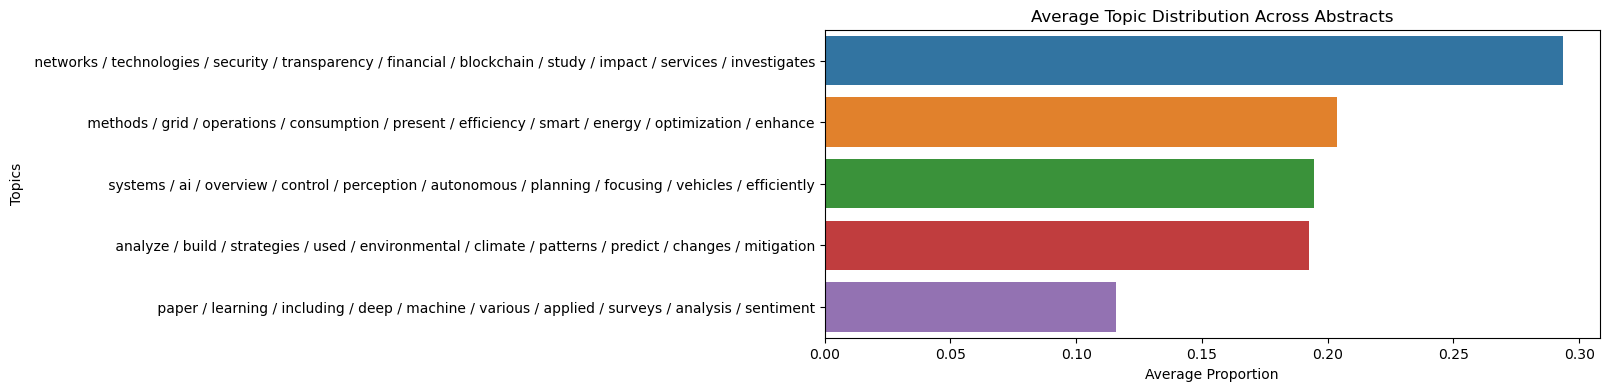

In [14]:
avg_dist = df_topics.mean().sort_values(ascending=False)
plt.figure(figsize=(10, 4))
sns.barplot(x=avg_dist.values, y=avg_dist.index)
plt.title("Average Topic Distribution Across Abstracts")
plt.xlabel("Average Proportion")
plt.ylabel("Topics")
plt.show()